# Micro-narrative analysis of _The Lord of the Rings_

In [1]:
import glob
import os.path

docs = []
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = text.split("\n")
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraphs import CooccurrenceGraph

if os.path.exists("lotr.db"):
    model = CooccurrenceGraph.load("lotr.db")
else:
    model = CooccurrenceGraph(
        sqlite_db_path="lotr.db",
        on_existing_db="overwrite"
    ).fit(docs)

In [3]:
model.cooccurrences_

,id,entity_one,entity_one_frequency,entity_two,entity_two_frequency,frequency,doc_frequency,spread,adjusted_tf_idf,pmi,entity_one_id,entity_two_id
0,1,three rings,36,elven,340,1,1,0.000108,0.0,1.834190,1,2
1,2,three rings,36,The skies,1494,1,1,0.000108,0.0,1.191318,1,3
2,3,elven,340,The skies,1494,2,2,0.000216,3080.0,0.517172,2,3
3,4,Dwarf,771,Hal,974,4,4,0.000433,5544.0,0.648418,4,5
4,5,Darkness,8600,Darkness,8600,44,41,0.004437,9460.0,-0.303573,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
284220,284221,Rose,93,Little Elanor,18,1,1,0.000108,0.0,2.698216,7881,16125
284221,284222,his lap,100,Rose,93,1,1,0.000108,0.0,1.953488,7807,7881
284222,284223,his chair,245,Little Elanor,18,1,1,0.000108,0.0,2.277533,2165,16125
284223,284224,his chair,245,his lap,100,1,1,0.000108,0.0,1.532805,2165,7807


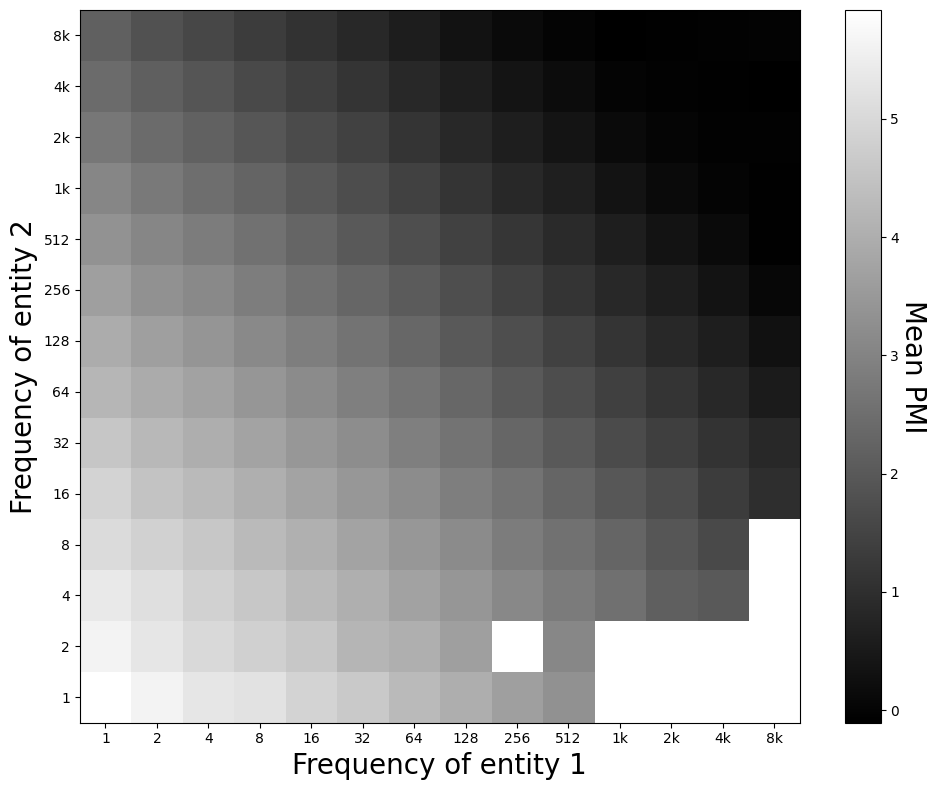

In [4]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

In [5]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_edge_frequency=1,
    minimum_node_frequency=3,
    maximum_node_frequency=100,
    maximum_edge_doc_frequency=20
)

In [6]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=2,
    community_detection_method_args=dict(k=3)
)

for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print(*[e.label for e in comm.members], sep=", ")
    print()

the dying fire, their slackening, the flakes

your little game, tea-time, decent places

your bonfire, And I, my pyre

`Steady, Steady, at least more feeling, the open passage

the Long List, Room tum, toom tum

the sweet mead, the blue vaults, Varda, Kindler, Mount Everwhite, the foaming waves, Valimar, swift draughts

the same birthday, September 22nd, his _tweens, the irresponsible twenties

the coming event, the chief topic, the older folk, their reminiscences, welcome demand

my one hundred and eleventh birthday, Hurray, Many Happy Returns

more wine, his own glass, the health

his VERY OWN, an umbrella, Adelard, many unlabelled ones

all the chief treasures, more than enough furniture, his possession, a penny-piece, a glass bead

his visits, all interest, the once familiar tap

only one Power, their effects, the only one, hobbit-lore, an obscure branch, old tree-roots

the influence, his own accord, an important point

fine lines, the finest pen-strokes, a flowing script, a great

In [7]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=2,
    community_detection_method_args=dict(resolution=4)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    members = [e.label for e in comm.members]
    print(*members, sep=", ")
    print()

now_, a high voice

the dying fire, their slackening, the flakes

your little game, tea-time, decent places

`Steady, Steady, at least more feeling, the open passage

the same birthday, September 22nd, his _tweens, the irresponsible twenties

the coming event, the chief topic, the older folk, their reminiscences, welcome demand

the younger generation, his audience

my one hundred and eleventh birthday, Hurray, Many Happy Returns

more wine, his own glass, the health

Well-preserved_, too much bread

only a joke, serious things

his VERY OWN, an umbrella, Adelard, many unlabelled ones

all the chief treasures, more than enough furniture, his possession, a penny-piece, a glass bead

a pony-trap, new milk

your help, all the beasts

his visits, all interest, the once familiar tap

a long-lived family, his mother's side

only one Power, their effects, the only one, hobbit-lore, an obscure branch, old tree-roots

the influence, his own accord, an important point

his breeches-pocket, if ei

In [ ]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()

INFO:     Started server process [1704]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
